# Residual Networks

Residual Networks (ResNets) are very deep CNN's which allow us to train networks without the issue of vanishing or exploding gradients as deep convolutional neural networks are practically harder to train and very complex functions.  Residual Networks are introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf)

Let's implement basic building blocks of ResNets in `tensorflow.keras` and perform a image classification task~ We use `tensorflow_v2` to build the model and below are required libraries we use~

In [12]:
# Import Required Lib's
import h5py
import tensorflow as tf
import numpy as np
from matplotlib.pyplot import imshow

from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image

## Building Residual Network

In resnets we build something called a "shorcut" or a "skip connection" which allows models to skip layers as shown below:

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<center> A ResNet block showing a skip-connection</center>

### Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<center><b>Identity block.</b> Skip connection "skips over" 2 layers. </center>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added.

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
 <center><b>Identity block.</b> Skip connection "skips over" 3 layers.</center>

In [2]:
# Identity Block
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implement Identity Block shown in the figures above
    Args:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: integer, specifying the shape of the middle CONV's window for the main path
        filters: python list of integers, defining the number of filters in the CONV layers of the main path
        training: to enable training or no
        initializer: to set up weights of layer

    Returns:
        X: output of identity block, tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)

    """
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. As we will need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters= F1, kernel_size= 1, strides= (1,1), padding= 'valid', kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X, training= training) # Default axis
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters= F2, kernel_size= f, strides= (1,1), padding= "same", kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X, training= training)
    X = Activation("relu")(X)

    # Third component of main path
    X = Conv2D(filters= F3, kernel_size= 1, strides= (1,1), padding= "valid", kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X, training= training)

    # Final Step: Add shortcut to main path and pass it to RELU activation
    X = Add()([X_shortcut, X])
    X = Activation("relu")(X)

    return X

### Convolutional Block

The other type of basic building block of a ResNet. We use this block when input and output dimensions don't match up. The only difference between `Identity` and `Convolutional` block is that the latter has a `Conv2d` in the shortcut path to match the dimension.

<img src="Images/convblock_kiank.png" style="width:650px;height:150px;">
<center><b> Convolutional block </b></center>

So, if we want to reduce the height and width of the activation dimensions by a factor of 2, we can use a `1x1` convolution with stride of 2. The `Conv2d` layer in shortcut doesn't need any activation function, it's main use is to just apply a linear function that reduces the dimensions of the input so that the dimensions match up for the later step.

In [3]:
# Convolutional Block
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    """
    Implement convolutional block as shows in the figure above
    Args:
        X: input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
        f: integer, specifying the shape of the middle CONV's window for the main path
        filters: python list of integers, defining the number of filters in the CONV layers of the main path
        s: Integer, specifying the stride to be used
        training: to enable training or no
        initializer: to set up weights of layer

    Returns:
        X - output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)

    """
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value for shortcut
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters= F1, kernel_size= 1, strides= (s, s), padding= 'valid', kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X, training= training)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters= F2, kernel_size= f, strides= (1,1), padding= "same", kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X, training= training)
    X = Activation("relu")(X)

    # Third component of main path
    X = Conv2D(filters= F3, kernel_size= 1, strides= (1,1), padding= "valid", kernel_initializer= initializer(seed=0))(X)
    X = BatchNormalization(axis= 3)(X, training= training)

    # Shortcut Path
    X_shortcut = Conv2D(filters= F3, kernel_size= 1, strides= (s,s), padding= "valid", kernel_initializer= initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis= 3)(X_shortcut, training= training)

    # Final Component
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## ResNet Model (50 Layers)

We have implemented blocks to build resnet now, the figure below shows details of the architecture of the network which will be used for reference when building the network~

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.
<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<center> <b>ResNet-50 model</b> </center>

In [4]:
# ResNet50 Model
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50: CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Args:
        input_shape: shape of images in dataset
        classes: an integer, number of classes

    Returns:
        model - a Model() instance in keras

    """
    # Define input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage - 1
    X = Conv2D(64, (7, 7), strides= (2, 2), kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis= 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides= (2, 2))(X)

    # Stage - 2
    X = convolutional_block(X, f= 3, filters= [64, 64, 256], s= 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f= 3, filters= [128,128,512], s= 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    # Stage 4
    X = convolutional_block(X, f= 3, filters= [256, 256, 1024], s= 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f= 3, filters= [512, 512, 2048], s= 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # Average Pooling
    X = AveragePooling2D((2, 2))(X)

    # Output Layer
    X = Flatten()(X)
    X = Dense(classes, activation= 'softmax', kernel_initializer= glorot_uniform(seed=0))(X)

    # Create Model
    model = Model(inputs= X_input, outputs= X)

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

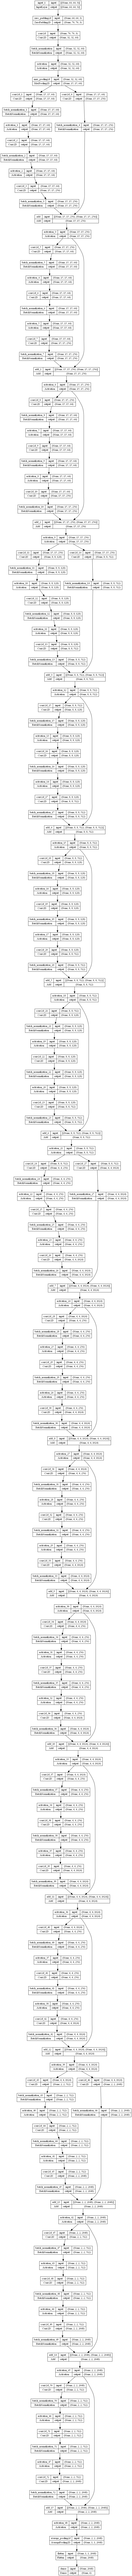

In [5]:
# Check Model Summary and plot model too if necessary to check sizes correctly
model = ResNet50(input_shape= (64, 64, 3), classes= 6)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model is ready to be trained now, lets load a dummy set to see how it works~

In [8]:
# Dummy Sign Values Set
def load_dataset():
    # Function to load data from destination
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # our train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # our train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # our test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # our test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def convert_to_one_hot(Y, C):
    # One-Hot encoding of labels
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [9]:
# Run Model for 10 epochs with a batch size of 32, on GPU
model.fit(X_train, Y_train, epochs= 10, batch_size= 32)

Epoch 1/10
34/34 [==============================] - 202s 4s/step - loss: 1.8645 - accuracy: 0.4815
Epoch 2/10
34/34 [==============================] - 66s 2s/step - loss: 0.6451 - accuracy: 0.8028
Epoch 3/10
34/34 [==============================] - 56s 2s/step - loss: 0.3700 - accuracy: 0.8815
Epoch 4/10
34/34 [==============================] - 28s 828ms/step - loss: 0.4009 - accuracy: 0.8722
Epoch 5/10
34/34 [==============================] - 51s 2s/step - loss: 0.2717 - accuracy: 0.9222
Epoch 6/10
34/34 [==============================] - 62s 2s/step - loss: 0.0901 - accuracy: 0.9741
Epoch 7/10
34/34 [==============================] - 39s 1s/step - loss: 0.2885 - accuracy: 0.9287
Epoch 8/10
34/34 [==============================] - 29s 866ms/step - loss: 0.2115 - accuracy: 0.9259
Epoch 9/10
34/34 [==============================] - 60s 2s/step - loss: 0.1945 - accuracy: 0.9426
Epoch 10/10
34/34 [==============================] - 84s 3s/step - loss: 0.1243 - accuracy: 0.9593


In [10]:
# Check predictions
preds = model.evaluate(X_test, Y_test)
print(f'Loss = {str(preds[0])}')
print(f'Test Accuracy = {str(preds[1])}')

4/4 [==============================] - 2s 321ms/step - loss: 0.2686 - accuracy: 0.9250
Loss = 0.26861679553985596
Test Accuracy = 0.925000011920929


Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 171s 171s/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.01197697 0.00182658 0.5421866  0.36859742 0.02217968 0.05323275]]
Class: 2


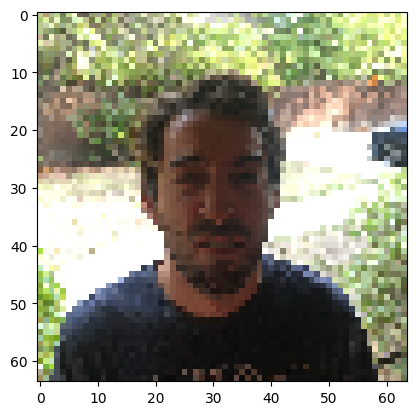

In [13]:
# Test on our own Image too~
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size= (64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis= 0)
x = x/255.

print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))

Ideally we would want to train longer for much better results but this quick training also shows very good results~